In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import os

# Librosa (the mother of audio files)
import librosa
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve

In [2]:
zero_crossings_mean=[]
zero_crossings_var = []
y_perc_mean=[] 
y_perc_var=[]
y_harm_mean=[] 
y_harm_var=[]
spectral_centroids_mean=[] 
spectral_centroids_var=[]
spectral_rolloff_mean=[]
spectral_rolloff_var=[]
chromagram_mean=[]
chromagram_var=[]
mfcc_mean=[]
mfcc_var=[]
labels= []

## 음악데이터 특정 컬럼 추출

In [3]:
def AudioFeatures(music):
    # Zero-crdssing
    wav, sr = librosa.load(f'./음악/{music}')
#     wav, sr = librosa.load(f'./Data/genres_original/classical/classical.00000.wav')
    
    zero_crossings = librosa.zero_crossings(wav, pad=False)
    zero_crossings_mean.append(zero_crossings.mean())
    zero_crossings_var.append(zero_crossings.var())

    #Harmonics and Perceptrual
    y_harm, y_perc = librosa.effects.hpss(wav)
    y_harm_mean.append(y_harm.mean())
    y_harm_var.append(y_harm.var())
    y_perc_mean.append(y_perc.mean())
    y_perc_var.append(y_perc.var())


    #Spectral Centroid / Rolloff
    spectral_centroids = librosa.feature.spectral_centroid(wav, sr=sr)[0]
    spectral_rolloff = librosa.feature.spectral_rolloff(wav, sr=sr)[0]

    spectral_centroids_mean.append(spectral_centroids.mean())
    spectral_centroids_var.append(spectral_centroids.var())
    spectral_rolloff_mean.append(spectral_rolloff.mean())
    spectral_rolloff_var.append(spectral_rolloff.var())

    #Mel-Frequency Cepstral Coefficients
    mfccs = librosa.feature.mfcc(wav, sr=sr)
    mfccs = sklearn.preprocessing.scale(mfccs, axis=1)
    mfcc_mean.append(mfccs.mean())
    mfcc_var.append(mfccs.var())

    #Chroma Frequencies
    hop_length = 5000
    chromagram = librosa.feature.chroma_stft(wav, sr=sr, hop_length=hop_length)
    chromagram_mean.append(chromagram.mean())
    chromagram_var.append(chromagram.var())

    #Label
    labels.append(music.split('.')[0])



In [3]:
musics = list(os.listdir('./음악/'))
for i in musics:
    AudioFeatures(i)

In [ ]:
music_df = {"zero_crossings_mean": zero_crossings_mean,"zero_crossings_var": zero_crossings_var ,"y_perc_mean": y_perc_mean, 
         "y_perc_var": y_perc_var, "y_harm_mean":y_harm_mean,"y_harm_var" : y_harm_var,"spectral_centroids_mean" : spectral_centroids_mean,
         "spectral_centroids_var" : spectral_centroids_var,"spectral_rolloff_mean" :spectral_rolloff_mean,"spectral_rolloff_var" : spectral_rolloff_var,
         "chromagram_mean" :chromagram_mean, "chromagram_var" :chromagram_var ,"mfcc_mean" :mfcc_mean, "mfcc_var" : mfcc_var, "labels" : labels 
        }
df = pd.DataFrame(music_df)

In [6]:
df['labels'].value_counts()

blues      100
country    100
disco      100
reggae     100
rock       100
Name: labels, dtype: int64

In [34]:
label_index = dict()
index_label = dict()
for i, x in enumerate(df.labels.unique()):
    label_index[x] = i
    index_label[i] = x
print(label_index)
df.labels = [label_index[l] for l in df.labels]

{'blues': 0, 'country': 1, 'disco': 2, 'reggae': 3, 'rock': 4}


In [35]:
y = df['labels']
X = df.loc[:, df.columns != 'labels']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [8]:
cols = X.columns
min_max_scaler = preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns = cols)

In [9]:
X_test = min_max_scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns = cols)

In [21]:
def model_assess(model,title = "Default"):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print('Accuracy', title, ':', round(accuracy_score(y_test, preds), 5), '\n')

In [22]:
nb = GaussianNB()
model_assess(nb, "Naive Bayes")

# Stochastic Gradient Descent
sgd = SGDClassifier(max_iter=5000, random_state=0)
model_assess(sgd, "Stochastic Gradient Descent")

# KNN
knn = KNeighborsClassifier(n_neighbors=19)
model_assess(knn, "KNN")

# Decission trees
tree = DecisionTreeClassifier()
model_assess(tree, "Decission trees")

# Random Forest
rforest = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=0)
model_assess(rforest, "Random Forest")

# Support Vector Machine
svm = SVC(decision_function_shape="ovo")
model_assess(svm, "Support Vector Machine")

# Logistic Regression
lg = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
model_assess(lg, "Logistic Regression")

# Neural Nets
nn = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5000, 10), random_state=1)
model_assess(nn, "Neural Nets")

# Cross Gradient Booster
xgb = XGBClassifier(n_estimators=1000, learning_rate=0.05)
model_assess(xgb, "Cross Gradient Booster")

# Cross Gradient Booster (Random Forest)
xgbrf = XGBRFClassifier(objective= 'multi:softmax')
model_assess(xgbrf, "Cross Gradient Booster (Random Forest)")

Accuracy Naive Bayes : 0.84 

Accuracy Stochastic Gradient Descent : 0.848 

Accuracy KNN : 0.848 

Accuracy Decission trees : 1.0 

Accuracy Random Forest : 0.984 

Accuracy Support Vector Machine : 0.92 

Accuracy Logistic Regression : 0.832 

Accuracy Neural Nets : 0.728 

[13:59:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy Cross Gradient Booster : 1.0 

[13:59:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy Cross Gradient Booster (Random Forest) : 1.0 



In [1]:
# rforest = RandomForestClassifier()
search_params = {
    'n_estimators'      : [100, 500,1000],
#     'criterion'         : ['gini', 'entropy'],
    'max_features'      : ["auto", 3,5,10, 20],
    'random_state'      : [2525,0],
#     'n_jobs'            : [1],
    'min_samples_split' : [3, 10, 20, 50, 100,150,200,300],
    'max_depth'         : [3, 10, 20, 50, 100,150,200,300]
#     'bootstrap'         : [False],#True
#     'oob_score'         : [False],#True
}
gs = GridSearchCV(RandomForestClassifier(),search_params, cv=5, verbose=True)
gs.fit(X_train, y_train)
preds = gs.predict(TestScaled)
print('Accuracy :', round(accuracy_score(y_test, preds), 5), '\n')

In [ ]:
pd.crosstab(y_test,rforest.predict(TestScaled))

In [184]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(estimator=rforest, random_state=1)
perm.fit(XScaled, y_train)

eli5.show_weights(estimator=perm, feature_names  = XScaled.columns.tolist())

Weight,Feature
0.0393 ± 0.0175,spectral_rolloff_var
0.0364 ± 0.0131,chromagram_var
0.0243 ± 0.0070,chromagram_mean
0.0229 ± 0.0073,y_harm_mean
0.0200 ± 0.0140,y_perc_var
0.0107 ± 0.0111,y_harm_var
0.0079 ± 0.0029,mfcc_mean
0.0071 ± 0.0000,spectral_rolloff_mean
0.0064 ± 0.0029,y_perc_mean
0.0057 ± 0.0035,mfcc_var


In [2]:
aa= pd.read_csv("./Data/features_30_sec.csv")
y = aa.label
aa.drop(["filename","label"], axis =1, inplace = True)

{'blues': 0, 'country': 1, 'disco': 2, 'reggae': 3, 'rock': 4}


In [17]:
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *

model = Sequential()
model.add(Dense(1024,input_shape=(X_train.shape[1],),activation='relu', kernel_regularizer = keras.regularizers.l2(0.001)))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu', kernel_regularizer = keras.regularizers.l2(0.001)))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu', kernel_regularizer = keras.regularizers.l2(0.003)))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu', kernel_regularizer = keras.regularizers.l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 1024)              16384     
                                                                 
 dropout_16 (Dropout)        (None, 1024)              0         
                                                                 
 dense_25 (Dense)            (None, 512)               524800    
                                                                 
 dropout_17 (Dropout)        (None, 512)               0         
                                                                 
 dense_26 (Dense)            (None, 256)               131328    
                                                                 
 dropout_18 (Dropout)        (None, 256)               0         
                                                                 
 dense_27 (Dense)            (None, 64)               

In [23]:
adam = keras.optimizers.Adam(lr=1e-4)
model.compile(optimizer=adam,
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])

In [82]:
import tensorflow as tf

tf.config.list_physical_devices('GPU')
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint,LearningRateScheduler
from datetime import datetime
# early_stopping= EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5) 
check_pointer = ModelCheckpoint(filepath = 'clf-resnet-checkpoint.hdf5',verbose=1,save_best_only=True) 
reduce_lr = ReduceLROnPlateau(monitor='val_loss',mode='min',verbose=1,patience=5,min_delta = 0.0001,factor=0.2) 
callbacks = [check_pointer,early_stopping,reduce_lr]

startTime = datetime.now()
with tf.device("/gpu:0"):
    hist = model.fit(XScaled, y_train,
                    validation_data = (TestScaled,y_test),
                    epochs = 600,
                    batch_size = 32
                    ,callbacks = [check_pointer]
#                      ,early_stopping
                        )
print("Time taken:", datetime.now() - startTime)

Epoch 1/600
12/12 [==============================] - 0s 22ms/step - loss: 0.9842 - accuracy: 0.7040 - val_loss: 1.1871 - val_accuracy: 0.6800

Epoch 00001: val_loss improved from inf to 1.18714, saving model to clf-resnet-checkpoint.hdf5
Epoch 2/600
12/12 [==============================] - 0s 19ms/step - loss: 0.9592 - accuracy: 0.6960 - val_loss: 1.1905 - val_accuracy: 0.6720

Epoch 00002: val_loss did not improve from 1.18714
Epoch 3/600
12/12 [==============================] - 0s 19ms/step - loss: 0.9867 - accuracy: 0.6907 - val_loss: 1.1789 - val_accuracy: 0.6720

Epoch 00003: val_loss improved from 1.18714 to 1.17892, saving model to clf-resnet-checkpoint.hdf5
Epoch 4/600
12/12 [==============================] - 0s 19ms/step - loss: 0.9719 - accuracy: 0.6613 - val_loss: 1.2052 - val_accuracy: 0.6560

Epoch 00004: val_loss did not improve from 1.17892
Epoch 5/600
12/12 [==============================] - 0s 15ms/step - loss: 0.9855 - accuracy: 0.6853 - val_loss: 1.1692 - val_accurac


Epoch 00041: val_loss did not improve from 1.15836
Epoch 42/600
12/12 [==============================] - 0s 14ms/step - loss: 0.9529 - accuracy: 0.6880 - val_loss: 1.1739 - val_accuracy: 0.6720

Epoch 00042: val_loss did not improve from 1.15836
Epoch 43/600
12/12 [==============================] - 0s 13ms/step - loss: 0.9978 - accuracy: 0.7120 - val_loss: 1.1751 - val_accuracy: 0.6640

Epoch 00043: val_loss did not improve from 1.15836
Epoch 44/600
12/12 [==============================] - 0s 14ms/step - loss: 0.9305 - accuracy: 0.7200 - val_loss: 1.1741 - val_accuracy: 0.6560

Epoch 00044: val_loss did not improve from 1.15836
Epoch 45/600
12/12 [==============================] - 0s 12ms/step - loss: 0.9519 - accuracy: 0.7253 - val_loss: 1.1805 - val_accuracy: 0.6640

Epoch 00045: val_loss did not improve from 1.15836
Epoch 46/600
12/12 [==============================] - 0s 13ms/step - loss: 0.9845 - accuracy: 0.7120 - val_loss: 1.1807 - val_accuracy: 0.6640

Epoch 00046: val_loss di

12/12 [==============================] - 0s 14ms/step - loss: 0.9247 - accuracy: 0.7227 - val_loss: 1.1751 - val_accuracy: 0.6480

Epoch 00084: val_loss did not improve from 1.15836
Epoch 85/600
12/12 [==============================] - 0s 14ms/step - loss: 0.9332 - accuracy: 0.7253 - val_loss: 1.1626 - val_accuracy: 0.6560

Epoch 00085: val_loss did not improve from 1.15836
Epoch 86/600
12/12 [==============================] - 0s 14ms/step - loss: 0.9432 - accuracy: 0.7200 - val_loss: 1.1857 - val_accuracy: 0.6560

Epoch 00086: val_loss did not improve from 1.15836
Epoch 87/600
12/12 [==============================] - 0s 16ms/step - loss: 0.9491 - accuracy: 0.7120 - val_loss: 1.1714 - val_accuracy: 0.6640

Epoch 00087: val_loss did not improve from 1.15836
Epoch 88/600
12/12 [==============================] - 0s 16ms/step - loss: 0.9099 - accuracy: 0.7413 - val_loss: 1.1909 - val_accuracy: 0.6560

Epoch 00088: val_loss did not improve from 1.15836
Epoch 89/600
12/12 [==================

12/12 [==============================] - 0s 14ms/step - loss: 0.8955 - accuracy: 0.7333 - val_loss: 1.1802 - val_accuracy: 0.6400

Epoch 00126: val_loss did not improve from 1.15836
Epoch 127/600
12/12 [==============================] - 0s 13ms/step - loss: 0.9051 - accuracy: 0.7200 - val_loss: 1.1823 - val_accuracy: 0.6640

Epoch 00127: val_loss did not improve from 1.15836
Epoch 128/600
12/12 [==============================] - 0s 13ms/step - loss: 0.9191 - accuracy: 0.7413 - val_loss: 1.1827 - val_accuracy: 0.6480

Epoch 00128: val_loss did not improve from 1.15836
Epoch 129/600
12/12 [==============================] - 0s 14ms/step - loss: 0.9009 - accuracy: 0.7200 - val_loss: 1.1723 - val_accuracy: 0.6720

Epoch 00129: val_loss did not improve from 1.15836
Epoch 130/600
12/12 [==============================] - 0s 14ms/step - loss: 0.9157 - accuracy: 0.7387 - val_loss: 1.1866 - val_accuracy: 0.6400

Epoch 00130: val_loss did not improve from 1.15836
Epoch 131/600
12/12 [=============

12/12 [==============================] - 0s 15ms/step - loss: 0.8697 - accuracy: 0.7547 - val_loss: 1.1803 - val_accuracy: 0.6560

Epoch 00168: val_loss did not improve from 1.15836
Epoch 169/600
12/12 [==============================] - 0s 15ms/step - loss: 0.8841 - accuracy: 0.7387 - val_loss: 1.1960 - val_accuracy: 0.6720

Epoch 00169: val_loss did not improve from 1.15836
Epoch 170/600
12/12 [==============================] - 0s 15ms/step - loss: 0.9014 - accuracy: 0.7387 - val_loss: 1.1990 - val_accuracy: 0.6480

Epoch 00170: val_loss did not improve from 1.15836
Epoch 171/600
12/12 [==============================] - 0s 13ms/step - loss: 0.8790 - accuracy: 0.7653 - val_loss: 1.1865 - val_accuracy: 0.6560

Epoch 00171: val_loss did not improve from 1.15836
Epoch 172/600
12/12 [==============================] - 0s 14ms/step - loss: 0.8774 - accuracy: 0.7467 - val_loss: 1.1885 - val_accuracy: 0.6480

Epoch 00172: val_loss did not improve from 1.15836
Epoch 173/600
12/12 [=============

12/12 [==============================] - 0s 15ms/step - loss: 0.8729 - accuracy: 0.7333 - val_loss: 1.1770 - val_accuracy: 0.6720

Epoch 00210: val_loss did not improve from 1.15836
Epoch 211/600
12/12 [==============================] - 0s 14ms/step - loss: 0.8658 - accuracy: 0.7573 - val_loss: 1.2029 - val_accuracy: 0.6640

Epoch 00211: val_loss did not improve from 1.15836
Epoch 212/600
12/12 [==============================] - 0s 14ms/step - loss: 0.8551 - accuracy: 0.7493 - val_loss: 1.1830 - val_accuracy: 0.6560

Epoch 00212: val_loss did not improve from 1.15836
Epoch 213/600
12/12 [==============================] - 0s 14ms/step - loss: 0.8252 - accuracy: 0.7707 - val_loss: 1.1942 - val_accuracy: 0.6720

Epoch 00213: val_loss did not improve from 1.15836
Epoch 214/600
12/12 [==============================] - 0s 13ms/step - loss: 0.8683 - accuracy: 0.7493 - val_loss: 1.2050 - val_accuracy: 0.6560

Epoch 00214: val_loss did not improve from 1.15836
Epoch 215/600
12/12 [=============

12/12 [==============================] - 0s 14ms/step - loss: 0.8634 - accuracy: 0.7520 - val_loss: 1.2061 - val_accuracy: 0.6400

Epoch 00252: val_loss did not improve from 1.15836
Epoch 253/600
12/12 [==============================] - 0s 14ms/step - loss: 0.8455 - accuracy: 0.7627 - val_loss: 1.2020 - val_accuracy: 0.6800

Epoch 00253: val_loss did not improve from 1.15836
Epoch 254/600
12/12 [==============================] - 0s 16ms/step - loss: 0.8737 - accuracy: 0.7547 - val_loss: 1.2061 - val_accuracy: 0.6640

Epoch 00254: val_loss did not improve from 1.15836
Epoch 255/600
12/12 [==============================] - 0s 14ms/step - loss: 0.8456 - accuracy: 0.7493 - val_loss: 1.1991 - val_accuracy: 0.6560

Epoch 00255: val_loss did not improve from 1.15836
Epoch 256/600
12/12 [==============================] - 0s 15ms/step - loss: 0.8334 - accuracy: 0.7600 - val_loss: 1.2193 - val_accuracy: 0.6880

Epoch 00256: val_loss did not improve from 1.15836
Epoch 257/600
12/12 [=============

12/12 [==============================] - 0s 17ms/step - loss: 0.8015 - accuracy: 0.7627 - val_loss: 1.2183 - val_accuracy: 0.6400

Epoch 00294: val_loss did not improve from 1.15836
Epoch 295/600
12/12 [==============================] - 0s 15ms/step - loss: 0.8396 - accuracy: 0.7467 - val_loss: 1.2157 - val_accuracy: 0.6400

Epoch 00295: val_loss did not improve from 1.15836
Epoch 296/600
12/12 [==============================] - 0s 16ms/step - loss: 0.8199 - accuracy: 0.7547 - val_loss: 1.2103 - val_accuracy: 0.6480

Epoch 00296: val_loss did not improve from 1.15836
Epoch 297/600
12/12 [==============================] - 0s 14ms/step - loss: 0.8681 - accuracy: 0.7360 - val_loss: 1.2289 - val_accuracy: 0.6240

Epoch 00297: val_loss did not improve from 1.15836
Epoch 298/600
12/12 [==============================] - 0s 15ms/step - loss: 0.8460 - accuracy: 0.7360 - val_loss: 1.2310 - val_accuracy: 0.6560

Epoch 00298: val_loss did not improve from 1.15836
Epoch 299/600
12/12 [=============

12/12 [==============================] - 0s 13ms/step - loss: 0.8279 - accuracy: 0.7707 - val_loss: 1.2089 - val_accuracy: 0.6320

Epoch 00336: val_loss did not improve from 1.15836
Epoch 337/600
12/12 [==============================] - 0s 13ms/step - loss: 0.8329 - accuracy: 0.7440 - val_loss: 1.2361 - val_accuracy: 0.6560

Epoch 00337: val_loss did not improve from 1.15836
Epoch 338/600
12/12 [==============================] - 0s 15ms/step - loss: 0.8199 - accuracy: 0.7547 - val_loss: 1.2135 - val_accuracy: 0.6240

Epoch 00338: val_loss did not improve from 1.15836
Epoch 339/600
12/12 [==============================] - 0s 15ms/step - loss: 0.8207 - accuracy: 0.7493 - val_loss: 1.2307 - val_accuracy: 0.6480

Epoch 00339: val_loss did not improve from 1.15836
Epoch 340/600
12/12 [==============================] - 0s 15ms/step - loss: 0.8176 - accuracy: 0.7760 - val_loss: 1.2390 - val_accuracy: 0.6400

Epoch 00340: val_loss did not improve from 1.15836
Epoch 341/600
12/12 [=============

12/12 [==============================] - 0s 13ms/step - loss: 0.8020 - accuracy: 0.7707 - val_loss: 1.2283 - val_accuracy: 0.6320

Epoch 00378: val_loss did not improve from 1.15836
Epoch 379/600
12/12 [==============================] - 0s 15ms/step - loss: 0.8040 - accuracy: 0.7787 - val_loss: 1.2381 - val_accuracy: 0.6400

Epoch 00379: val_loss did not improve from 1.15836
Epoch 380/600
12/12 [==============================] - 0s 14ms/step - loss: 0.8138 - accuracy: 0.7413 - val_loss: 1.2510 - val_accuracy: 0.6160

Epoch 00380: val_loss did not improve from 1.15836
Epoch 381/600
12/12 [==============================] - 0s 14ms/step - loss: 0.8280 - accuracy: 0.7493 - val_loss: 1.2511 - val_accuracy: 0.6560

Epoch 00381: val_loss did not improve from 1.15836
Epoch 382/600
12/12 [==============================] - 0s 13ms/step - loss: 0.7727 - accuracy: 0.7867 - val_loss: 1.2433 - val_accuracy: 0.6400

Epoch 00382: val_loss did not improve from 1.15836
Epoch 383/600
12/12 [=============

12/12 [==============================] - 0s 13ms/step - loss: 0.7706 - accuracy: 0.7733 - val_loss: 1.2415 - val_accuracy: 0.6480

Epoch 00420: val_loss did not improve from 1.15836
Epoch 421/600
12/12 [==============================] - 0s 14ms/step - loss: 0.7730 - accuracy: 0.7893 - val_loss: 1.2399 - val_accuracy: 0.6400

Epoch 00421: val_loss did not improve from 1.15836
Epoch 422/600
12/12 [==============================] - 0s 13ms/step - loss: 0.7935 - accuracy: 0.7947 - val_loss: 1.2338 - val_accuracy: 0.6400

Epoch 00422: val_loss did not improve from 1.15836
Epoch 423/600
12/12 [==============================] - 0s 14ms/step - loss: 0.7747 - accuracy: 0.7653 - val_loss: 1.2213 - val_accuracy: 0.6400

Epoch 00423: val_loss did not improve from 1.15836
Epoch 424/600
12/12 [==============================] - 0s 14ms/step - loss: 0.7818 - accuracy: 0.7760 - val_loss: 1.2421 - val_accuracy: 0.6640

Epoch 00424: val_loss did not improve from 1.15836
Epoch 425/600
12/12 [=============

12/12 [==============================] - 0s 13ms/step - loss: 0.7558 - accuracy: 0.7947 - val_loss: 1.2679 - val_accuracy: 0.6400

Epoch 00462: val_loss did not improve from 1.15836
Epoch 463/600
12/12 [==============================] - 0s 13ms/step - loss: 0.7978 - accuracy: 0.7893 - val_loss: 1.2617 - val_accuracy: 0.6240

Epoch 00463: val_loss did not improve from 1.15836
Epoch 464/600
12/12 [==============================] - 0s 14ms/step - loss: 0.7426 - accuracy: 0.7867 - val_loss: 1.2494 - val_accuracy: 0.6400

Epoch 00464: val_loss did not improve from 1.15836
Epoch 465/600
12/12 [==============================] - 0s 14ms/step - loss: 0.7619 - accuracy: 0.8000 - val_loss: 1.2756 - val_accuracy: 0.6720

Epoch 00465: val_loss did not improve from 1.15836
Epoch 466/600
12/12 [==============================] - 0s 14ms/step - loss: 0.7459 - accuracy: 0.8027 - val_loss: 1.2613 - val_accuracy: 0.6640

Epoch 00466: val_loss did not improve from 1.15836
Epoch 467/600
12/12 [=============

12/12 [==============================] - 0s 15ms/step - loss: 0.7541 - accuracy: 0.8000 - val_loss: 1.2698 - val_accuracy: 0.6480

Epoch 00504: val_loss did not improve from 1.15836
Epoch 505/600
12/12 [==============================] - 0s 14ms/step - loss: 0.7503 - accuracy: 0.7867 - val_loss: 1.2800 - val_accuracy: 0.6560

Epoch 00505: val_loss did not improve from 1.15836
Epoch 506/600
12/12 [==============================] - 0s 18ms/step - loss: 0.7391 - accuracy: 0.7867 - val_loss: 1.2723 - val_accuracy: 0.6560

Epoch 00506: val_loss did not improve from 1.15836
Epoch 507/600
12/12 [==============================] - 0s 17ms/step - loss: 0.7419 - accuracy: 0.7920 - val_loss: 1.2817 - val_accuracy: 0.6640

Epoch 00507: val_loss did not improve from 1.15836
Epoch 508/600
12/12 [==============================] - 0s 15ms/step - loss: 0.7384 - accuracy: 0.8133 - val_loss: 1.2874 - val_accuracy: 0.6320

Epoch 00508: val_loss did not improve from 1.15836
Epoch 509/600
12/12 [=============


Epoch 00545: val_loss did not improve from 1.15836
Epoch 546/600
12/12 [==============================] - 0s 13ms/step - loss: 0.7295 - accuracy: 0.7947 - val_loss: 1.2990 - val_accuracy: 0.6560

Epoch 00546: val_loss did not improve from 1.15836
Epoch 547/600
12/12 [==============================] - 0s 13ms/step - loss: 0.7035 - accuracy: 0.8347 - val_loss: 1.2966 - val_accuracy: 0.6320

Epoch 00547: val_loss did not improve from 1.15836
Epoch 548/600
12/12 [==============================] - 0s 15ms/step - loss: 0.7338 - accuracy: 0.8133 - val_loss: 1.3006 - val_accuracy: 0.6080

Epoch 00548: val_loss did not improve from 1.15836
Epoch 549/600
12/12 [==============================] - 0s 11ms/step - loss: 0.7121 - accuracy: 0.8267 - val_loss: 1.3061 - val_accuracy: 0.6400

Epoch 00549: val_loss did not improve from 1.15836
Epoch 550/600
12/12 [==============================] - 0s 11ms/step - loss: 0.7169 - accuracy: 0.8080 - val_loss: 1.2966 - val_accuracy: 0.6400

Epoch 00550: val_lo


Epoch 00587: val_loss did not improve from 1.15836
Epoch 588/600
12/12 [==============================] - 0s 16ms/step - loss: 0.6935 - accuracy: 0.8240 - val_loss: 1.3203 - val_accuracy: 0.6400

Epoch 00588: val_loss did not improve from 1.15836
Epoch 589/600
12/12 [==============================] - 0s 15ms/step - loss: 0.6903 - accuracy: 0.8160 - val_loss: 1.3180 - val_accuracy: 0.6320

Epoch 00589: val_loss did not improve from 1.15836
Epoch 590/600
12/12 [==============================] - 0s 16ms/step - loss: 0.6829 - accuracy: 0.8347 - val_loss: 1.3392 - val_accuracy: 0.6560

Epoch 00590: val_loss did not improve from 1.15836
Epoch 591/600
12/12 [==============================] - 0s 14ms/step - loss: 0.7127 - accuracy: 0.8240 - val_loss: 1.3101 - val_accuracy: 0.6400

Epoch 00591: val_loss did not improve from 1.15836
Epoch 592/600
12/12 [==============================] - 0s 14ms/step - loss: 0.7308 - accuracy: 0.7973 - val_loss: 1.3243 - val_accuracy: 0.6160

Epoch 00592: val_lo

<Figure size 1440x1080 with 0 Axes>

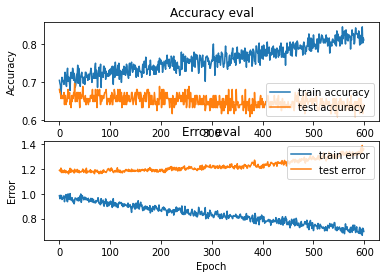

In [84]:
plt.figure(figsize=(20,15))
fig, axs = plt.subplots(2)

# accuracy 
axs[0].plot(hist.history["accuracy"], label="train accuracy")
axs[0].plot(hist.history["val_accuracy"], label="test accuracy")    
axs[0].set_ylabel("Accuracy")
axs[0].legend(loc="lower right")
axs[0].set_title("Accuracy eval")
    
# Error 
axs[1].plot(hist.history["loss"], label="train error")
axs[1].plot(hist.history["val_loss"], label="test error")    
axs[1].set_ylabel("Error")
axs[1].set_xlabel("Epoch")
axs[1].legend(loc="upper right")
axs[1].set_title("Error eval")
    
plt.show()

In [86]:
test_loss,test_acc=model.evaluate(TestScaled,y_test,batch_size=128)
print("The test loss is ",test_loss)
print("The best accuracy is: ",test_acc*100)

1/1 [==============================] - 0s 16ms/step - loss: 1.3572 - accuracy: 0.6400
The test loss is  1.357243537902832
The best accuracy is:  63.999998569488525
